In [12]:
import torch
from torch import nn
import numpy as np 
from matplotlib import pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F

from simple_deep_learning.mnist_extended.semantic_segmentation import create_semantic_segmentation_dataset
from simple_deep_learning.mnist_extended.semantic_segmentation import display_grayscale_array, plot_class_masks, display_segmented_image
from custom.dataset import SegmentationDataloader
from custom.unet import UNET

In [26]:
NUM_CLASSES = 1
NUM_EPOCHS = 20
LR = 0.001
BATCH_SIZE = 32
NAME = "UNET_1_class"

In [27]:
def train():
    np.random.seed(1)
    train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(num_train_samples=1000,
                                                                            num_test_samples=200,
                                                                            image_shape=(60, 60),
                                                                            max_num_digits_per_image=4,
                                                                            num_classes=NUM_CLASSES)

    model = UNET(in_channels=1, num_classes=NUM_CLASSES)

    # pytorch expects the channels to be the first dimension
    train_x = torch.moveaxis(torch.tensor(train_x, dtype=torch.float32), 3, 1)
    train_y = torch.moveaxis(torch.tensor(train_y, dtype=torch.float32), 3, 1)
    test_x = torch.moveaxis(torch.tensor(test_x, dtype=torch.float32), 3, 1)
    test_y = torch.moveaxis(torch.tensor(test_y, dtype=torch.float32), 3, 1)

    # convert to binary labels and make them exclusive
    new_train_y = torch.zeros_like(train_y).scatter(1, train_y.argmax(dim=1, keepdim=True), value=1)
    new_train_y[train_y < 0.5] = 0
    train_y = new_train_y

    new_test_y = torch.zeros_like(test_y).scatter(1, test_y.argmax(dim=1, keepdim=True), value=1)
    new_test_y[test_y < 0.5] = 0
    test_y = new_test_y

    optimizer = Adam(
        model.parameters(), 
        lr = LR,
    )

    loss_fn = nn.BCELoss()
    train_loader = SegmentationDataloader(train_x, train_y, batch_size=BATCH_SIZE)
    eval_loader = SegmentationDataloader(test_x, test_y, batch_size=BATCH_SIZE)

    def train():
        model.train()
        loss_arr = np.array([])
        optimizer.zero_grad()
        for input in train_loader:
            x, y = input
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_arr = np.append(loss_arr, loss.detach().numpy().item())
        print(f"Training loss: {loss.mean()}")
        return loss.detach().numpy().mean()

    def eval():
        model.eval()
        loss_arr = np.array([])
        with torch.no_grad():
            for input in eval_loader:
                x, y = input
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss_arr = np.append(loss_arr, loss.detach().numpy().item())
        print(f"Validation loss: {loss.mean()}")
        return loss.detach().numpy().mean()

    LOGS = {
        "train_loss": [],
        "eval_loss": []
    }

    best_eval_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch}")
        train_loss = train()
        eval_loss = eval()
        LOGS["train_loss"].append(train_loss)
        LOGS["eval_loss"].append(eval_loss)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            print(f"New best model found: {best_eval_loss}")
            torch.save(model.state_dict(), "./{}.pth".format(NAME))

    return model, train_x, train_y, test_x, test_y

Epoch 0
Training loss: 0.38932478427886963
Validation loss: 83.06741333007812
New best model found: 83.06741333007812
Epoch 1
Training loss: 0.3171504735946655
Validation loss: 0.2817078232765198
New best model found: 0.2817078232765198
Epoch 2
Training loss: 0.29123201966285706
Validation loss: 0.30978021025657654
Epoch 3
Training loss: 0.2385772168636322
Validation loss: 0.2892157733440399
Epoch 4
Training loss: 0.17342914640903473
Validation loss: 0.16694259643554688
New best model found: 0.16694259643554688
Epoch 5
Training loss: 0.14785011112689972
Validation loss: 0.16198472678661346
New best model found: 0.16198472678661346
Epoch 6
Training loss: 0.12368706613779068
Validation loss: 0.12853944301605225
New best model found: 0.12853944301605225
Epoch 7
Training loss: 0.17617958784103394
Validation loss: 0.1811334639787674
Epoch 8
Training loss: 0.1889442801475525
Validation loss: 0.19291234016418457
Epoch 9
Training loss: 0.1451714038848877
Validation loss: 0.1370457410812378
Epo

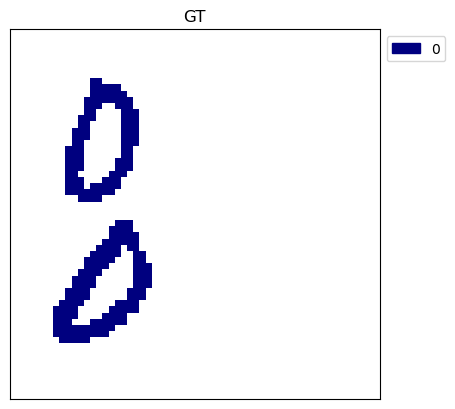

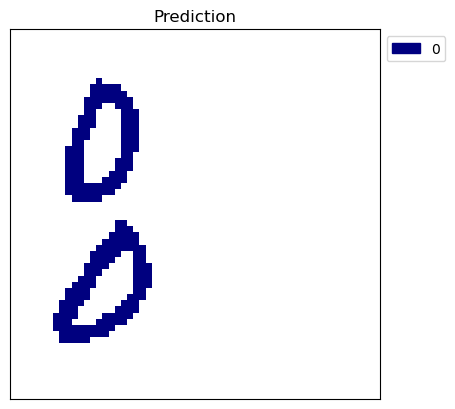

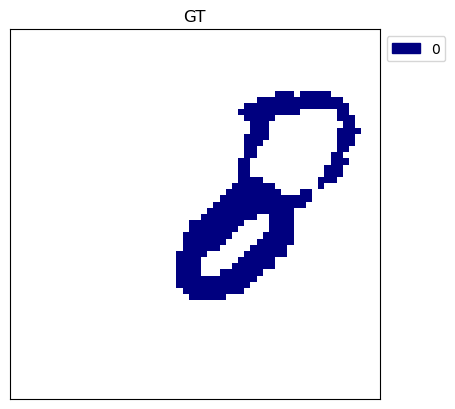

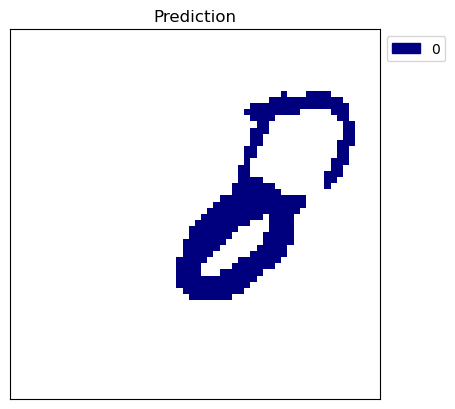

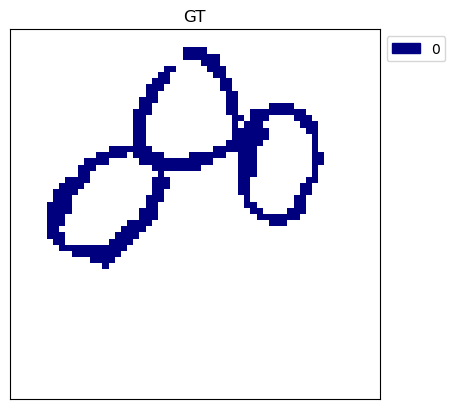

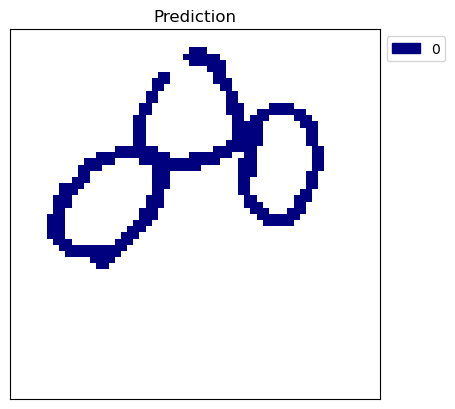

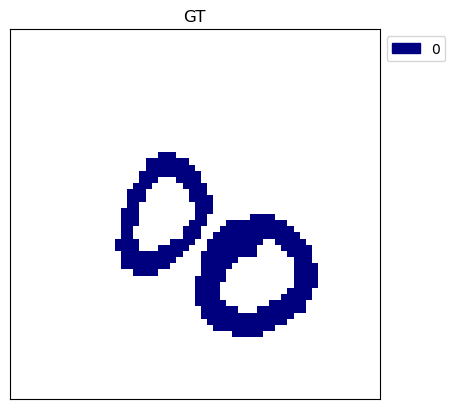

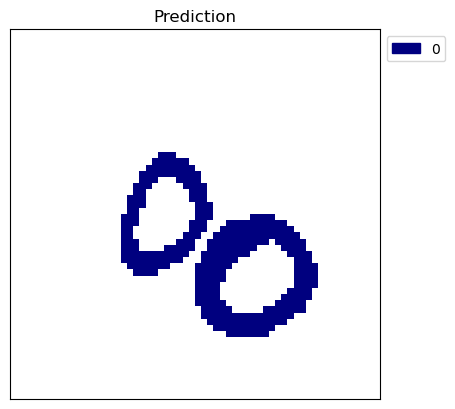

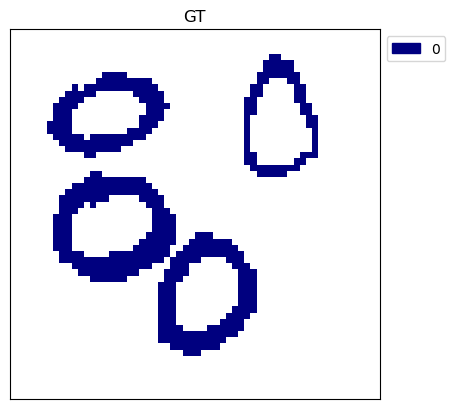

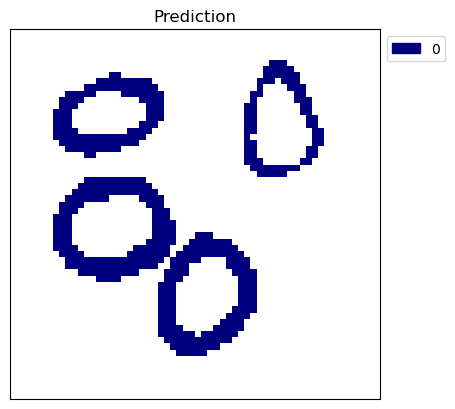

In [28]:
model, train_x, train_y, test_x, test_y = train()
model.load_state_dict(torch.load("./{}.pth".format(NAME)))
model.eval()
for i in range(5):
    display_segmented_image(torch.moveaxis(test_y, 1, 3)[i], title="GT")
    display_segmented_image(torch.moveaxis(model(test_x[i: i+1]), 1, 3)[0], title="Prediction")


Epoch 0
Training loss: 0.4977172613143921
Validation loss: 0.5742799639701843
New best model found: 0.5742799639701843
Epoch 1
Training loss: 0.3416141867637634
Validation loss: 0.32495421171188354
New best model found: 0.32495421171188354
Epoch 2
Training loss: 0.2479952871799469
Validation loss: 0.2590254247188568
New best model found: 0.2590254247188568
Epoch 3
Training loss: 0.182844877243042
Validation loss: 0.16548869013786316
New best model found: 0.16548869013786316
Epoch 4
Training loss: 0.1394815295934677
Validation loss: 0.12945570051670074
New best model found: 0.12945570051670074
Epoch 5
Training loss: 0.12122076004743576
Validation loss: 0.09518516063690186
New best model found: 0.09518516063690186
Epoch 6
Training loss: 0.09594309329986572
Validation loss: 0.10375785082578659
Epoch 7
Training loss: 0.07054924964904785
Validation loss: 0.0850917249917984
New best model found: 0.0850917249917984
Epoch 8
Training loss: 0.0851481631398201
Validation loss: 0.08675894141197205

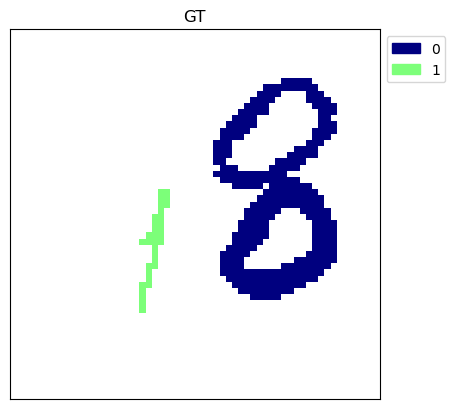

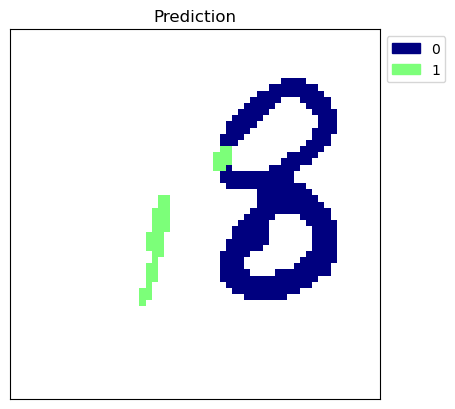

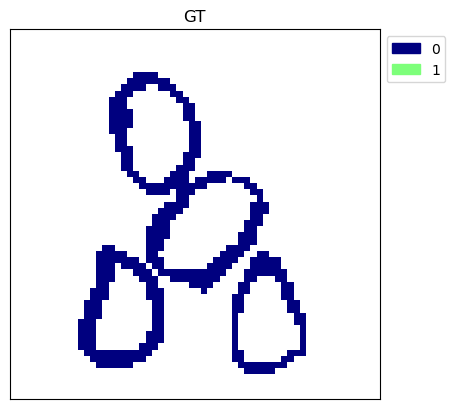

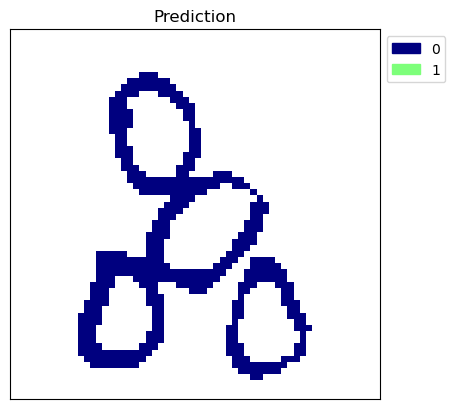

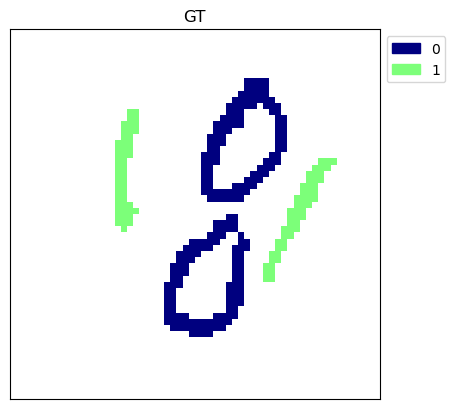

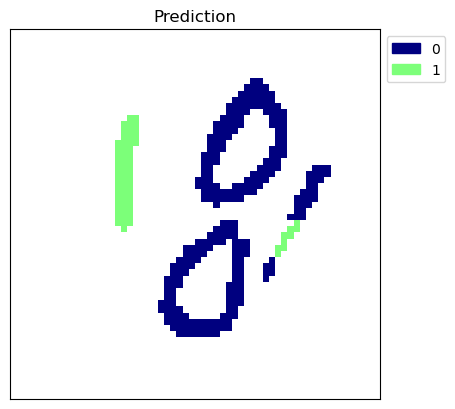

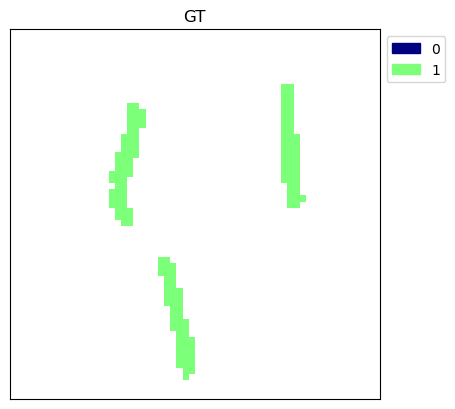

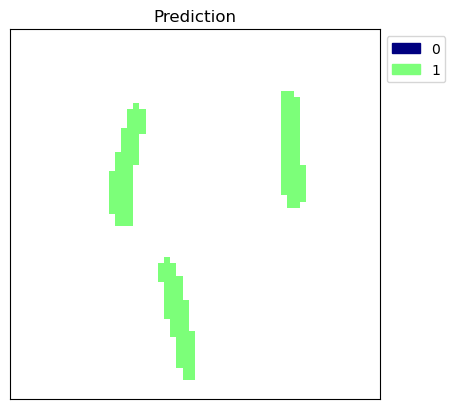

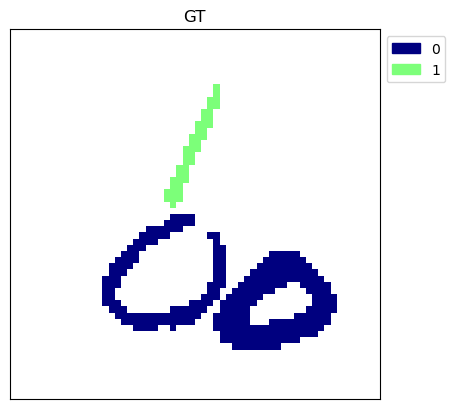

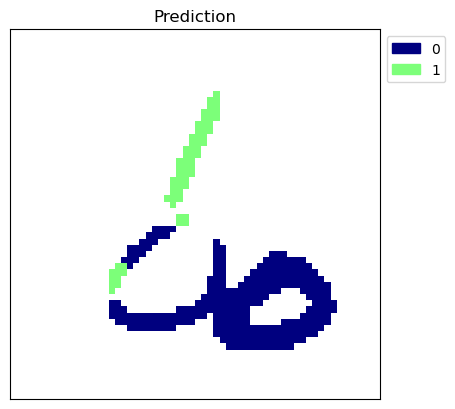

In [29]:
NUM_CLASSES = 2
NAME = "UNET_2_class"

model, train_x, train_y, test_x, test_y = train()
model.load_state_dict(torch.load("./{}.pth".format(NAME)))
model.eval()
for i in range(5):
    display_segmented_image(torch.moveaxis(test_y, 1, 3)[i], title="GT")
    display_segmented_image(torch.moveaxis(model(test_x[i: i+1]), 1, 3)[0], title="Prediction")

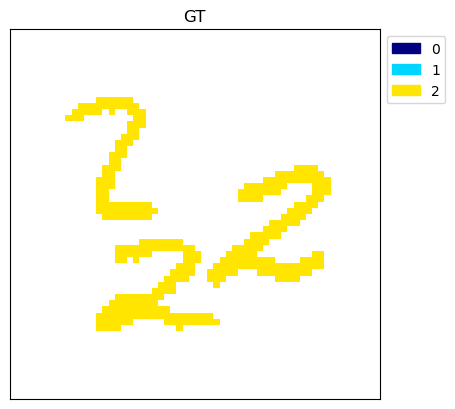

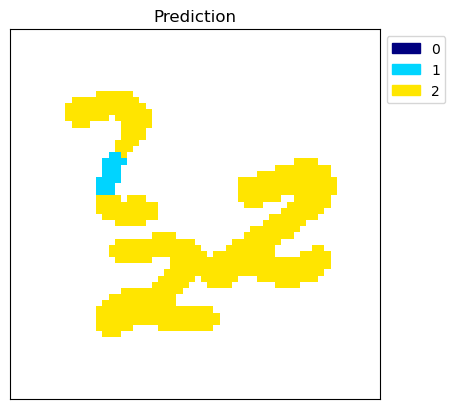

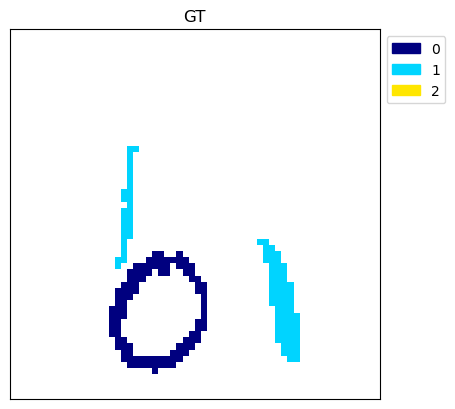

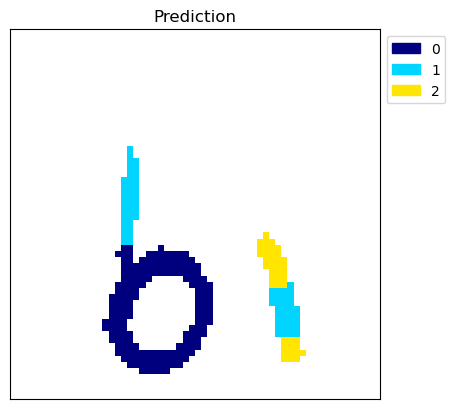

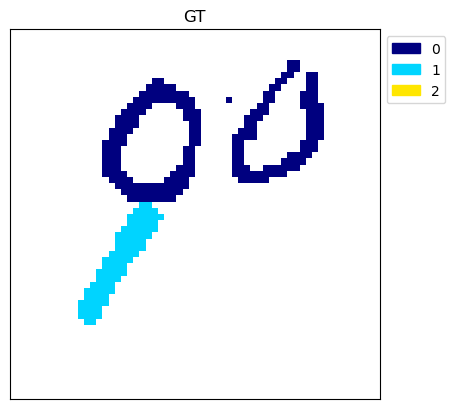

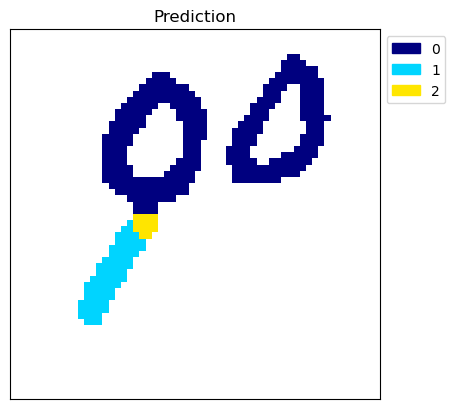

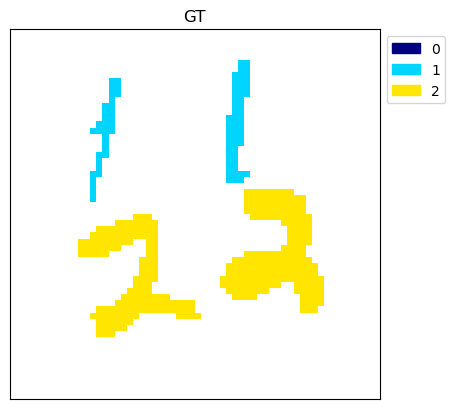

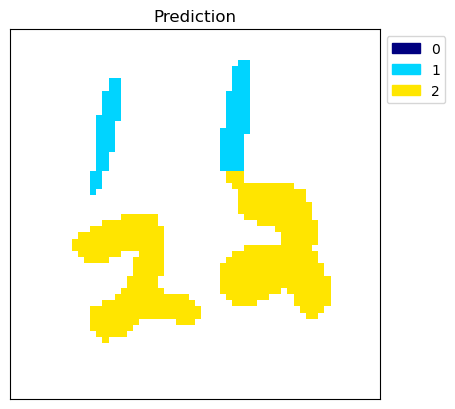

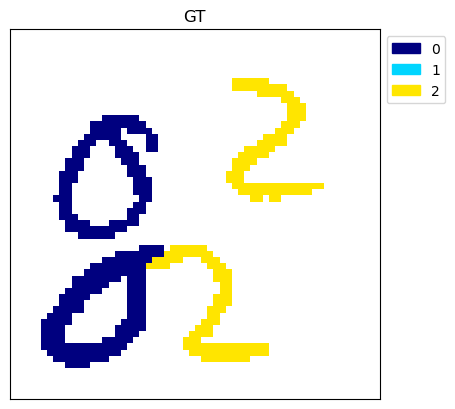

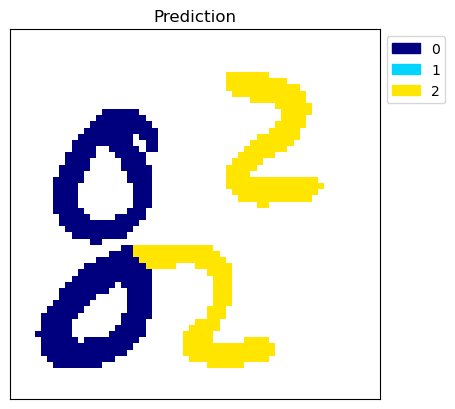

In [31]:
NUM_CLASSES = 3
NAME = "UNET_3_class"

model, train_x, train_y, test_x, test_y = train()
model.load_state_dict(torch.load("./{}.pth".format(NAME)))
model.eval()
for i in range(5):
    display_segmented_image(torch.moveaxis(test_y, 1, 3)[i], title="GT")
    display_segmented_image(torch.moveaxis(model(test_x[i: i+1]), 1, 3)[0], title="Prediction", threshold=0.2)

Epoch 0
Training loss: 0.5486869215965271
Validation loss: 47.335792541503906
New best model found: 47.335792541503906
Epoch 1
Training loss: 0.3887965679168701
Validation loss: 0.35330337285995483
New best model found: 0.35330337285995483
Epoch 2
Training loss: 0.2678247094154358
Validation loss: 0.33224931359291077
New best model found: 0.33224931359291077
Epoch 3
Training loss: 0.1876010000705719
Validation loss: 0.17356616258621216
New best model found: 0.17356616258621216
Epoch 4
Training loss: 0.14211416244506836
Validation loss: 0.1412312388420105
New best model found: 0.1412312388420105
Epoch 5
Training loss: 0.11225178837776184
Validation loss: 0.12095273286104202
New best model found: 0.12095273286104202
Epoch 6
Training loss: 0.1120513305068016
Validation loss: 0.08993726223707199
New best model found: 0.08993726223707199
Epoch 7
Training loss: 0.09228372573852539
Validation loss: 0.09629731625318527
Epoch 8
Training loss: 0.09040418267250061
Validation loss: 0.0738411992788

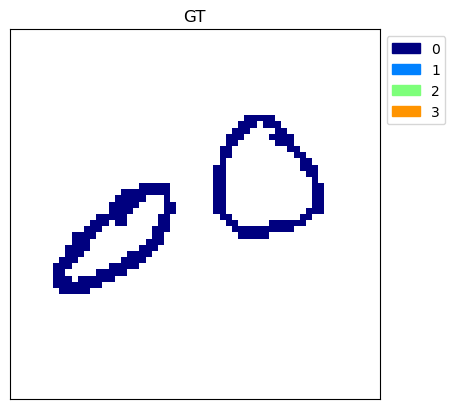

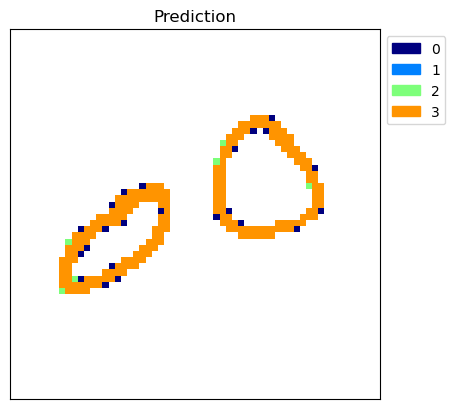

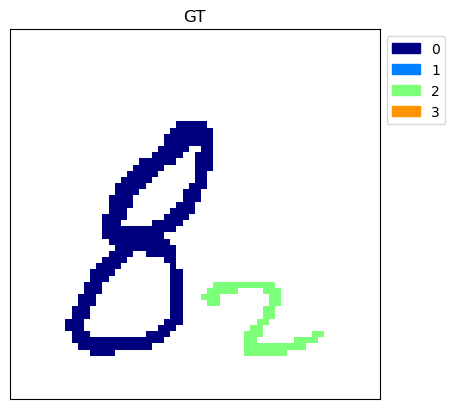

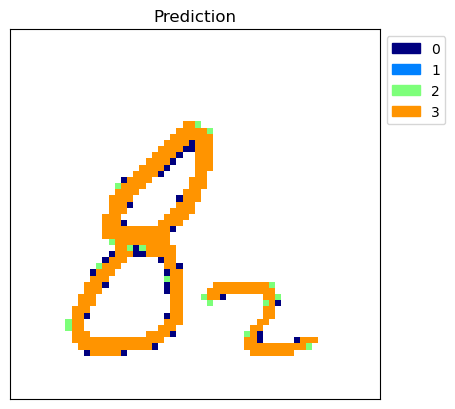

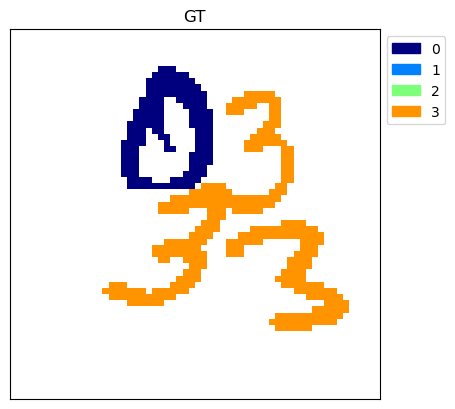

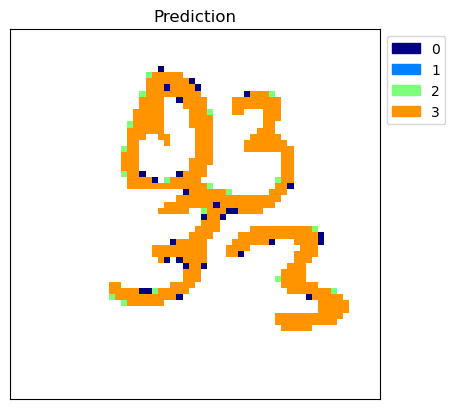

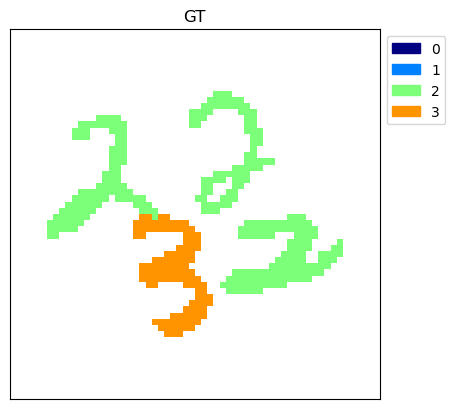

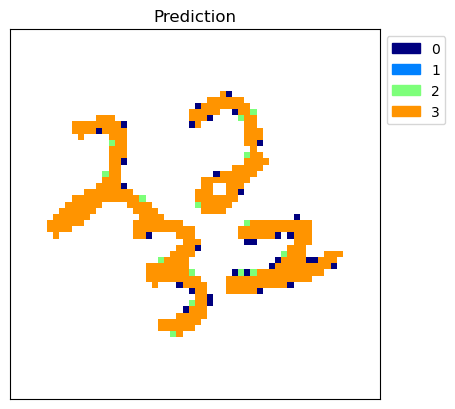

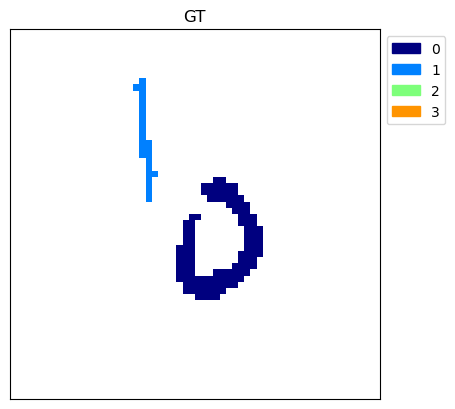

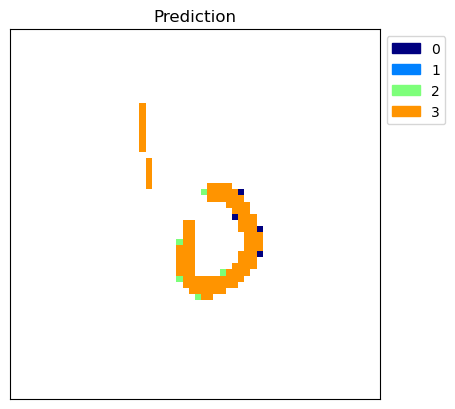

In [32]:
NUM_CLASSES = 4
NAME = "UNET_4_class"

model, train_x, train_y, test_x, test_y = train()
model.load_state_dict(torch.load("./{}.pth".format(NAME)))
model.eval()
for i in range(5):
    display_segmented_image(torch.moveaxis(test_y, 1, 3)[i], title="GT")
    display_segmented_image(torch.moveaxis(model(test_x[i: i+1]), 1, 3)[0], title="Prediction", threshold=0.2)